In [40]:
from importlib import reload
import os
from toolz import pipe as p

import matplotlib.pyplot as plt
import numpy as np

from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import trainModel
import visualizeModel

import localResnet
import scrapDataHelpers

In [41]:
%matplotlib inline

In [42]:
device = torch.device("cuda")

# Load Images

In [43]:
def createDataloaders(data_dir, input_size=224): 
    xs = ['train', 'val']

    data_transforms = trainModel.create_data_transforms(input_size, input_size)
    
    image_datasets = {x: p(data_dir, 
                           lambda _:os.path.join(_, x),
                           lambda _: datasets.ImageFolder(_, data_transforms[x])
                          )
                      for x in xs}

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers = 4)
                   for x in xs}

    dataset_sizes = {x: len(image_datasets[x]) for x in xs}
    
    return image_datasets, dataloaders, dataset_sizes

In [44]:
data_dir = 'scrap_data1500/'
image_datasets, dataloaders, dataset_sizes = createDataloaders(data_dir)

In [45]:
class_names = image_datasets['train'].classes

In [46]:
n_classes = len(class_names)
print(class_names, n_classes)

['gossiping', 'isolation', 'laughing', 'nonbullying', 'pullinghair', 'punching', 'quarrel', 'slapping', 'stabbing', 'strangle'] 10


In [48]:
scrapDataHelpers.classPercentages('scrap_data1500/')

{('train', 'strangle'): 14.51505016722408,
 ('val', 'strangle'): 14.410905550146055,
 ('train', 'quarrel'): 9.899665551839465,
 ('val', 'quarrel'): 9.931840311587147,
 ('train', 'gossiping'): 16.387959866220736,
 ('val', 'gossiping'): 16.358325219084712,
 ('train', 'pullinghair'): 10.367892976588628,
 ('val', 'pullinghair'): 10.321324245374878,
 ('train', 'nonbullying'): 3.9464882943143813,
 ('val', 'nonbullying'): 3.992210321324245,
 ('train', 'isolation'): 10.033444816053512,
 ('val', 'isolation'): 10.029211295034079,
 ('train', 'slapping'): 8.494983277591974,
 ('val', 'slapping'): 8.471275559883155,
 ('train', 'laughing'): 6.220735785953177,
 ('val', 'laughing'): 6.329113924050633,
 ('train', 'punching'): 14.51505016722408,
 ('val', 'punching'): 14.50827653359299,
 ('train', 'stabbing'): 5.618729096989967,
 ('val', 'stabbing'): 5.647517039922103}

# Visualize

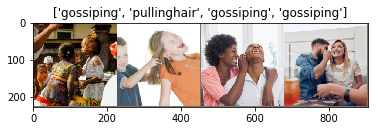

In [49]:
reload(visualizeModel)

inputs, classes = p(dataloaders['train'], iter, next)

out = torchvision.utils.make_grid(inputs)

visualizeModel.imshow(out, trainModel.defaultMn, trainModel.defaultSd, 
                      title=[class_names[x] for x in classes])

# Simple Model

In [50]:
reload(localResnet)
model = localResnet.ResNet([2, 2, 2], n_classes).to(device)

In [55]:
model

ResNet(
  (preres): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ResLayer(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ResLayer(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [57]:
?optim.Adam

In [62]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=.4)

In [63]:
model = trainModel.train_model(model, nn.CrossEntropyLoss(),
                               optimizer,
                               lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
                               dataloaders, dataset_sizes,
                               device,
                               writer = SummaryWriter('runs/simple_resnet')
                              )

Epoch 0/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.0213 Acc: 0.6528
val Loss: 2.1805 Acc: 0.4177
Epoch 1/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.9379 Acc: 0.6796
val Loss: 1.9624 Acc: 0.4391
Epoch 2/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.9178 Acc: 0.7017
val Loss: 1.8276 Acc: 0.4674
Epoch 3/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8402 Acc: 0.7064
val Loss: 1.8635 Acc: 0.4742
Epoch 4/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8059 Acc: 0.7271
val Loss: 2.4340 Acc: 0.4537
Epoch 5/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.7356 Acc: 0.7391
val Loss: 2.1347 Acc: 0.4469
Epoch 6/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.6780 Acc: 0.7692
val Loss: 2.2566 Acc: 0.4226
Epoch 7/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4218 Acc: 0.8722
val Loss: 1.6832 Acc: 0.5297
Epoch 8/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3493 Acc: 0.9003
val Loss: 1.6886 Acc: 0.5336
Epoch 9/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.2596 Acc: 0.9371
val Loss: 1.7268 Acc: 0.5375
Epoch 10/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.2558 Acc: 0.9338
val Loss: 1.7131 Acc: 0.5336
Epoch 11/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.2185 Acc: 0.9418
val Loss: 1.6853 Acc: 0.5404
Epoch 12/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.2075 Acc: 0.9532
val Loss: 1.7573 Acc: 0.5375
Epoch 13/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1948 Acc: 0.9585
val Loss: 1.8113 Acc: 0.5511
Epoch 14/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1718 Acc: 0.9632
val Loss: 1.7958 Acc: 0.5365
Epoch 15/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1671 Acc: 0.9579
val Loss: 1.7911 Acc: 0.5472
Epoch 16/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1649 Acc: 0.9692
val Loss: 1.7950 Acc: 0.5492
Epoch 17/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1672 Acc: 0.9666
val Loss: 1.7756 Acc: 0.5424
Epoch 18/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1641 Acc: 0.9639
val Loss: 1.8423 Acc: 0.5453
Epoch 19/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1672 Acc: 0.9686
val Loss: 1.7944 Acc: 0.5433
Epoch 20/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1641 Acc: 0.9666
val Loss: 1.8028 Acc: 0.5355
Epoch 21/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1475 Acc: 0.9759
val Loss: 1.8158 Acc: 0.5443
Epoch 22/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1560 Acc: 0.9706
val Loss: 1.7736 Acc: 0.5326
Epoch 23/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1695 Acc: 0.9645
val Loss: 1.7811 Acc: 0.5579
Epoch 24/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1621 Acc: 0.9719
val Loss: 1.7657 Acc: 0.5521


In [66]:
reload(localResnet)
model = localResnet.ResNet([2, 2, 2], n_classes, in_channels=32).to(device)

In [71]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=.7)
model = trainModel.train_model(model, nn.CrossEntropyLoss(),
                               optimizer,
                               lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
                               dataloaders, dataset_sizes,
                               device,
                               writer = SummaryWriter('runs/32_channels/3')
                              )

Epoch 0/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.0443 Acc: 0.6468
val Loss: 2.0136 Acc: 0.4294
Epoch 1/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.9601 Acc: 0.6562
val Loss: 1.8426 Acc: 0.4528
Epoch 2/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.9067 Acc: 0.7003
val Loss: 1.7472 Acc: 0.5005
Epoch 3/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8473 Acc: 0.7177
val Loss: 2.3224 Acc: 0.4382
Epoch 4/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.7974 Acc: 0.7304
val Loss: 1.9753 Acc: 0.4693
Epoch 5/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.7507 Acc: 0.7431
val Loss: 2.1109 Acc: 0.4537
Epoch 6/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.7060 Acc: 0.7572
val Loss: 2.0059 Acc: 0.4537
Epoch 7/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3940 Acc: 0.8943
val Loss: 1.6656 Acc: 0.5453
Epoch 8/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3281 Acc: 0.9184
val Loss: 1.7461 Acc: 0.5365
Epoch 9/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.2596 Acc: 0.9318
val Loss: 1.7751 Acc: 0.5355
Epoch 10/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.2520 Acc: 0.9378
val Loss: 1.8182 Acc: 0.5433
Epoch 11/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.2329 Acc: 0.9425
val Loss: 1.8619 Acc: 0.5443
Epoch 12/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.2098 Acc: 0.9525
val Loss: 1.8144 Acc: 0.5540
Epoch 13/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1926 Acc: 0.9552
val Loss: 1.8237 Acc: 0.5463
Epoch 14/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1744 Acc: 0.9612
val Loss: 1.8540 Acc: 0.5453
Epoch 15/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1840 Acc: 0.9585
val Loss: 1.8832 Acc: 0.5492
Epoch 16/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1651 Acc: 0.9639
val Loss: 1.9095 Acc: 0.5482
Epoch 17/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1682 Acc: 0.9686
val Loss: 1.8705 Acc: 0.5560
Epoch 18/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1836 Acc: 0.9599
val Loss: 1.8741 Acc: 0.5501
Epoch 19/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1762 Acc: 0.9639
val Loss: 1.8586 Acc: 0.5550
Epoch 20/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1746 Acc: 0.9605
val Loss: 1.8389 Acc: 0.5550
Epoch 21/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1574 Acc: 0.9726
val Loss: 1.8770 Acc: 0.5531
Epoch 22/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1672 Acc: 0.9625
val Loss: 1.8962 Acc: 0.5560
Epoch 23/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1596 Acc: 0.9672
val Loss: 1.8978 Acc: 0.5463
Epoch 24/24
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1745 Acc: 0.9559
val Loss: 1.8576 Acc: 0.5521


# Visualize Results

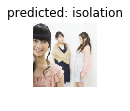

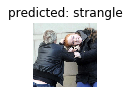

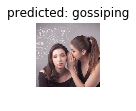

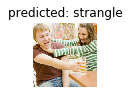

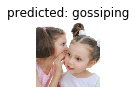

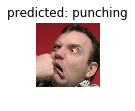

In [72]:
visualizeModel.visualize_model(model, dataloaders, device, class_names, 
                           trainModel.defaultMn, 
                           trainModel.defaultSd, k='val')

# Final Model

In [91]:
data_dir = 'main_train_set/'
image_datasets, dataloaders, dataset_sizes = createDataloaders(data_dir)

model_final = localResnet.ResNet([2, 2, 2], n_classes, in_channels=32).to(device)

In [92]:
optimizer = optim.SGD(model_final.parameters(), lr=0.1, momentum=.7)
model_final = trainModel.train_model(model_final, nn.CrossEntropyLoss(),
                               optimizer,
                               lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
                               dataloaders, dataset_sizes,
                               device,
                               writer = SummaryWriter('runs/final'),
                               num_epochs = 50
                              )

Epoch 0/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 2.2695 Acc: 0.1820
val Loss: 2.3194 Acc: 0.1333
Epoch 1/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 2.1427 Acc: 0.2268
val Loss: 2.2613 Acc: 0.2000
Epoch 2/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 2.0804 Acc: 0.2557
val Loss: 2.2492 Acc: 0.1000
Epoch 3/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 2.0173 Acc: 0.2827
val Loss: 2.2693 Acc: 0.1667
Epoch 4/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.9548 Acc: 0.3243
val Loss: 2.1991 Acc: 0.2667
Epoch 5/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.9022 Acc: 0.3366
val Loss: 2.1603 Acc: 0.3000
Epoch 6/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.8385 Acc: 0.3612
val Loss: 2.0365 Acc: 0.1667
Epoch 7/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.6570 Acc: 0.4429
val Loss: 1.9139 Acc: 0.2667
Epoch 8/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.6046 Acc: 0.4508
val Loss: 1.8195 Acc: 0.3667
Epoch 9/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.5866 Acc: 0.4627
val Loss: 1.7451 Acc: 0.3667
Epoch 10/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.5607 Acc: 0.4667
val Loss: 1.8335 Acc: 0.3333
Epoch 11/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.5351 Acc: 0.4758
val Loss: 1.7682 Acc: 0.2667
Epoch 12/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.5169 Acc: 0.4841
val Loss: 1.7283 Acc: 0.3333
Epoch 13/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.4944 Acc: 0.4937
val Loss: 1.7321 Acc: 0.3667
Epoch 14/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.4243 Acc: 0.5262
val Loss: 1.5990 Acc: 0.3667
Epoch 15/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.4235 Acc: 0.5226
val Loss: 1.5789 Acc: 0.4000
Epoch 16/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.4089 Acc: 0.5131
val Loss: 1.5750 Acc: 0.4333
Epoch 17/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3859 Acc: 0.5329
val Loss: 1.5619 Acc: 0.4000
Epoch 18/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.4027 Acc: 0.5297
val Loss: 1.5632 Acc: 0.4667
Epoch 19/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.4083 Acc: 0.5313
val Loss: 1.5504 Acc: 0.4333
Epoch 20/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3824 Acc: 0.5329
val Loss: 1.5672 Acc: 0.4000
Epoch 21/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3787 Acc: 0.5369
val Loss: 1.5237 Acc: 0.4333
Epoch 22/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3915 Acc: 0.5329
val Loss: 1.5374 Acc: 0.4333
Epoch 23/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3820 Acc: 0.5389
val Loss: 1.5326 Acc: 0.4000
Epoch 24/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3785 Acc: 0.5369
val Loss: 1.5453 Acc: 0.3667
Epoch 25/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3639 Acc: 0.5361
val Loss: 1.5277 Acc: 0.4000
Epoch 26/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3859 Acc: 0.5325
val Loss: 1.5409 Acc: 0.4333
Epoch 27/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3652 Acc: 0.5436
val Loss: 1.5403 Acc: 0.5000
Epoch 28/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3756 Acc: 0.5381
val Loss: 1.5120 Acc: 0.4000
Epoch 29/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3701 Acc: 0.5337
val Loss: 1.5305 Acc: 0.4000
Epoch 30/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3714 Acc: 0.5353
val Loss: 1.5117 Acc: 0.4667
Epoch 31/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3792 Acc: 0.5337
val Loss: 1.5338 Acc: 0.3667
Epoch 32/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3751 Acc: 0.5436
val Loss: 1.5117 Acc: 0.4333
Epoch 33/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3565 Acc: 0.5460
val Loss: 1.5772 Acc: 0.3667
Epoch 34/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3658 Acc: 0.5400
val Loss: 1.5513 Acc: 0.3667
Epoch 35/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3772 Acc: 0.5313
val Loss: 1.5636 Acc: 0.3333
Epoch 36/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3706 Acc: 0.5424
val Loss: 1.5142 Acc: 0.4000
Epoch 37/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3631 Acc: 0.5523
val Loss: 1.5981 Acc: 0.4333
Epoch 38/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3744 Acc: 0.5448
val Loss: 1.5380 Acc: 0.4333
Epoch 39/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3713 Acc: 0.5420
val Loss: 1.5514 Acc: 0.5000
Epoch 40/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3661 Acc: 0.5496
val Loss: 1.5430 Acc: 0.4000
Epoch 41/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3700 Acc: 0.5377
val Loss: 1.5269 Acc: 0.4667
Epoch 42/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3648 Acc: 0.5515
val Loss: 1.5212 Acc: 0.4000
Epoch 43/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3561 Acc: 0.5456
val Loss: 1.5483 Acc: 0.4333
Epoch 44/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3727 Acc: 0.5400
val Loss: 1.5176 Acc: 0.4333
Epoch 45/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3738 Acc: 0.5385
val Loss: 1.5412 Acc: 0.4000
Epoch 46/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3696 Acc: 0.5389
val Loss: 1.5082 Acc: 0.4000
Epoch 47/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3872 Acc: 0.5393
val Loss: 1.4894 Acc: 0.5333
Epoch 48/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3678 Acc: 0.5341
val Loss: 1.5355 Acc: 0.3667
Epoch 49/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3647 Acc: 0.5373
val Loss: 1.5498 Acc: 0.4333


__Run Another 50__

In [93]:
optimizer = optim.SGD(model_final.parameters(), lr=0.1, momentum=.7)
model_final = trainModel.train_model(model_final, nn.CrossEntropyLoss(),
                               optimizer,
                               lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
                               dataloaders, dataset_sizes,
                               device,
                               writer = SummaryWriter('runs/final2'),
                               num_epochs = 50
                              )

Epoch 0/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.7577 Acc: 0.3918
val Loss: 2.4263 Acc: 0.2000
Epoch 1/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.6907 Acc: 0.4310
val Loss: 2.0858 Acc: 0.2667
Epoch 2/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.6246 Acc: 0.4457
val Loss: 2.0125 Acc: 0.2667
Epoch 3/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.5682 Acc: 0.4762
val Loss: 1.8922 Acc: 0.3667
Epoch 4/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.5388 Acc: 0.4722
val Loss: 2.2360 Acc: 0.4000
Epoch 5/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.4690 Acc: 0.4992
val Loss: 1.7330 Acc: 0.2000
Epoch 6/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.4330 Acc: 0.5250
val Loss: 1.5277 Acc: 0.5000
Epoch 7/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.1909 Acc: 0.5944
val Loss: 1.3761 Acc: 0.5667
Epoch 8/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.1122 Acc: 0.6193
val Loss: 1.2424 Acc: 0.6000
Epoch 9/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.0836 Acc: 0.6293
val Loss: 1.1791 Acc: 0.6000
Epoch 10/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.0466 Acc: 0.6463
val Loss: 1.2292 Acc: 0.6000
Epoch 11/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.0227 Acc: 0.6519
val Loss: 1.1701 Acc: 0.5333
Epoch 12/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.0050 Acc: 0.6574
val Loss: 1.1909 Acc: 0.6333
Epoch 13/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.9778 Acc: 0.6768
val Loss: 1.0396 Acc: 0.6667
Epoch 14/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.9152 Acc: 0.6998
val Loss: 1.1347 Acc: 0.6333
Epoch 15/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8951 Acc: 0.7034
val Loss: 1.0011 Acc: 0.7333
Epoch 16/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.9007 Acc: 0.7098
val Loss: 1.0442 Acc: 0.6667
Epoch 17/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8836 Acc: 0.6975
val Loss: 0.9315 Acc: 0.7333
Epoch 18/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8899 Acc: 0.6987
val Loss: 0.9836 Acc: 0.7000
Epoch 19/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8739 Acc: 0.6979
val Loss: 0.9471 Acc: 0.6667
Epoch 20/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8861 Acc: 0.7054
val Loss: 0.9569 Acc: 0.7000
Epoch 21/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8729 Acc: 0.7006
val Loss: 0.9109 Acc: 0.7000
Epoch 22/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8575 Acc: 0.7185
val Loss: 0.9845 Acc: 0.6667
Epoch 23/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8646 Acc: 0.7157
val Loss: 0.9689 Acc: 0.7000
Epoch 24/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8702 Acc: 0.7129
val Loss: 1.0560 Acc: 0.6667
Epoch 25/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8658 Acc: 0.7050
val Loss: 0.9748 Acc: 0.6667
Epoch 26/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8523 Acc: 0.7105
val Loss: 0.9754 Acc: 0.7000
Epoch 27/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8789 Acc: 0.7026
val Loss: 1.0089 Acc: 0.6667
Epoch 28/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8655 Acc: 0.7034
val Loss: 1.1021 Acc: 0.6000
Epoch 29/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8599 Acc: 0.7173
val Loss: 1.0181 Acc: 0.7000
Epoch 30/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8746 Acc: 0.7098
val Loss: 0.9841 Acc: 0.7000
Epoch 31/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8670 Acc: 0.7201
val Loss: 0.9725 Acc: 0.7333
Epoch 32/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8631 Acc: 0.7141
val Loss: 0.9609 Acc: 0.7000
Epoch 33/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8627 Acc: 0.7137
val Loss: 0.9565 Acc: 0.7000
Epoch 34/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8753 Acc: 0.7094
val Loss: 1.0108 Acc: 0.6667
Epoch 35/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8732 Acc: 0.7046
val Loss: 0.9950 Acc: 0.6667
Epoch 36/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8549 Acc: 0.7165
val Loss: 1.0427 Acc: 0.6667
Epoch 37/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8715 Acc: 0.7086
val Loss: 0.9521 Acc: 0.7000
Epoch 38/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8686 Acc: 0.7117
val Loss: 0.9354 Acc: 0.7333
Epoch 39/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8726 Acc: 0.7078
val Loss: 0.9329 Acc: 0.7000
Epoch 40/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8654 Acc: 0.7058
val Loss: 0.9761 Acc: 0.7000
Epoch 41/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8594 Acc: 0.7161
val Loss: 0.9650 Acc: 0.7000
Epoch 42/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8695 Acc: 0.7157
val Loss: 0.9921 Acc: 0.6667
Epoch 43/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8725 Acc: 0.7098
val Loss: 0.9965 Acc: 0.7000
Epoch 44/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8693 Acc: 0.7105
val Loss: 1.0006 Acc: 0.7000
Epoch 45/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8719 Acc: 0.7094
val Loss: 0.9685 Acc: 0.6667
Epoch 46/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8706 Acc: 0.7050
val Loss: 0.9582 Acc: 0.6667
Epoch 47/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8643 Acc: 0.7074
val Loss: 0.9575 Acc: 0.6667
Epoch 48/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8799 Acc: 0.7026
val Loss: 0.9444 Acc: 0.7000
Epoch 49/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8571 Acc: 0.7165
val Loss: 0.9557 Acc: 0.7000


__Run Another 50__

In [94]:
optimizer = optim.SGD(model_final.parameters(), lr=0.1, momentum=.7)
model_final = trainModel.train_model(model_final, nn.CrossEntropyLoss(),
                               optimizer,
                               lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
                               dataloaders, dataset_sizes,
                               device,
                               writer = SummaryWriter('runs/final3'),
                               num_epochs = 50
                              )

Epoch 0/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.3391 Acc: 0.5448
val Loss: 1.5797 Acc: 0.5000
Epoch 1/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.2739 Acc: 0.5623
val Loss: 1.3135 Acc: 0.4333
Epoch 2/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.2037 Acc: 0.5860
val Loss: 1.4774 Acc: 0.6000
Epoch 3/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.1726 Acc: 0.6019
val Loss: 1.0684 Acc: 0.6667
Epoch 4/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.1284 Acc: 0.6082
val Loss: 1.1070 Acc: 0.6000
Epoch 5/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.0708 Acc: 0.6301
val Loss: 1.1268 Acc: 0.6667
Epoch 6/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.0211 Acc: 0.6495
val Loss: 1.3155 Acc: 0.5000
Epoch 7/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.7296 Acc: 0.7641
val Loss: 0.6936 Acc: 0.8000
Epoch 8/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.6362 Acc: 0.7994
val Loss: 0.5929 Acc: 0.8333
Epoch 9/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.6166 Acc: 0.8021
val Loss: 0.5659 Acc: 0.8000
Epoch 10/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.5882 Acc: 0.8101
val Loss: 0.5522 Acc: 0.8667
Epoch 11/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.5259 Acc: 0.8224
val Loss: 0.5546 Acc: 0.9000
Epoch 12/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.5171 Acc: 0.8422
val Loss: 0.5518 Acc: 0.8333
Epoch 13/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4898 Acc: 0.8462
val Loss: 0.4902 Acc: 0.9000
Epoch 14/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4528 Acc: 0.8592
val Loss: 0.4348 Acc: 0.8333
Epoch 15/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4320 Acc: 0.8636
val Loss: 0.4281 Acc: 0.8667
Epoch 16/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4235 Acc: 0.8715
val Loss: 0.4209 Acc: 0.9000
Epoch 17/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4340 Acc: 0.8660
val Loss: 0.4332 Acc: 0.8667
Epoch 18/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4102 Acc: 0.8719
val Loss: 0.4241 Acc: 0.9000
Epoch 19/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4221 Acc: 0.8680
val Loss: 0.4122 Acc: 0.9000
Epoch 20/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4031 Acc: 0.8767
val Loss: 0.4236 Acc: 0.9333
Epoch 21/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4097 Acc: 0.8826
val Loss: 0.4096 Acc: 0.8333
Epoch 22/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4002 Acc: 0.8783
val Loss: 0.4272 Acc: 0.9333
Epoch 23/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3946 Acc: 0.8807
val Loss: 0.4502 Acc: 0.8667
Epoch 24/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4134 Acc: 0.8771
val Loss: 0.4123 Acc: 0.8667
Epoch 25/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4150 Acc: 0.8747
val Loss: 0.4476 Acc: 0.9000
Epoch 26/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4029 Acc: 0.8830
val Loss: 0.4229 Acc: 0.9000
Epoch 27/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4079 Acc: 0.8751
val Loss: 0.3905 Acc: 0.9000
Epoch 28/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3928 Acc: 0.8854
val Loss: 0.4087 Acc: 0.8667
Epoch 29/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4152 Acc: 0.8719
val Loss: 0.4168 Acc: 0.9000
Epoch 30/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4062 Acc: 0.8735
val Loss: 0.4191 Acc: 0.8667
Epoch 31/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3977 Acc: 0.8838
val Loss: 0.4268 Acc: 0.9000
Epoch 32/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4046 Acc: 0.8719
val Loss: 0.4081 Acc: 0.9333
Epoch 33/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4035 Acc: 0.8751
val Loss: 0.4327 Acc: 0.8333
Epoch 34/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3922 Acc: 0.8795
val Loss: 0.4064 Acc: 0.8333
Epoch 35/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4061 Acc: 0.8735
val Loss: 0.4498 Acc: 0.8333
Epoch 36/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3991 Acc: 0.8814
val Loss: 0.4297 Acc: 0.8667
Epoch 37/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3957 Acc: 0.8803
val Loss: 0.4245 Acc: 0.9000
Epoch 38/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4054 Acc: 0.8795
val Loss: 0.4096 Acc: 0.8667
Epoch 39/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4002 Acc: 0.8810
val Loss: 0.4375 Acc: 0.8333
Epoch 40/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4002 Acc: 0.8743
val Loss: 0.4136 Acc: 0.9000
Epoch 41/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3937 Acc: 0.8830
val Loss: 0.4472 Acc: 0.9000
Epoch 42/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3942 Acc: 0.8834
val Loss: 0.4678 Acc: 0.9000
Epoch 43/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4014 Acc: 0.8755
val Loss: 0.4149 Acc: 0.8667
Epoch 44/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4109 Acc: 0.8759
val Loss: 0.4526 Acc: 0.9000
Epoch 45/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3934 Acc: 0.8862
val Loss: 0.4376 Acc: 0.9000
Epoch 46/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3983 Acc: 0.8791
val Loss: 0.4458 Acc: 0.8333
Epoch 47/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4040 Acc: 0.8751
val Loss: 0.4257 Acc: 0.8667
Epoch 48/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3989 Acc: 0.8810
val Loss: 0.5351 Acc: 0.8333
Epoch 49/49
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4093 Acc: 0.8775
val Loss: 0.4301 Acc: 0.9333


__Run Another 20__

In [95]:
optimizer = optim.SGD(model_final.parameters(), lr=0.1, momentum=.7)
model_final = trainModel.train_model(model_final, nn.CrossEntropyLoss(),
                               optimizer,
                               lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
                               dataloaders, dataset_sizes,
                               device,
                               writer = SummaryWriter('runs/final4'),
                               num_epochs = 20
                              )

Epoch 0/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.9780 Acc: 0.6602
val Loss: 0.9799 Acc: 0.6333
Epoch 1/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8979 Acc: 0.6788
val Loss: 3.2242 Acc: 0.2333
Epoch 2/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.8407 Acc: 0.7078
val Loss: 1.1131 Acc: 0.5333
Epoch 3/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.7680 Acc: 0.7415
val Loss: 0.5814 Acc: 0.8667
Epoch 4/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.7389 Acc: 0.7470
val Loss: 0.7823 Acc: 0.7000
Epoch 5/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.6967 Acc: 0.7522
val Loss: 1.1154 Acc: 0.6667
Epoch 6/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.6325 Acc: 0.7827
val Loss: 0.5287 Acc: 0.8667
Epoch 7/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3576 Acc: 0.8882
val Loss: 0.3035 Acc: 0.9333
Epoch 8/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.2907 Acc: 0.9163
val Loss: 0.2955 Acc: 0.9000
Epoch 9/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.2443 Acc: 0.9350
val Loss: 0.2484 Acc: 0.9333
Epoch 10/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.2330 Acc: 0.9374
val Loss: 0.1839 Acc: 0.9667
Epoch 11/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.2107 Acc: 0.9465
val Loss: 0.1968 Acc: 0.9333
Epoch 12/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1999 Acc: 0.9449
val Loss: 0.1571 Acc: 0.9667
Epoch 13/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1608 Acc: 0.9596
val Loss: 0.1368 Acc: 0.9667
Epoch 14/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1593 Acc: 0.9564
val Loss: 0.1253 Acc: 0.9667
Epoch 15/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1504 Acc: 0.9651
val Loss: 0.1201 Acc: 0.9667
Epoch 16/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1478 Acc: 0.9651
val Loss: 0.1323 Acc: 0.9667
Epoch 17/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1446 Acc: 0.9683
val Loss: 0.1285 Acc: 0.9667
Epoch 18/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1503 Acc: 0.9655
val Loss: 0.1323 Acc: 0.9667
Epoch 19/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1426 Acc: 0.9651
val Loss: 0.1286 Acc: 0.9333


__Run Another 20__

In [96]:
optimizer = optim.SGD(model_final.parameters(), lr=0.1, momentum=.7)
model_final = trainModel.train_model(model_final, nn.CrossEntropyLoss(),
                               optimizer,
                               lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
                               dataloaders, dataset_sizes,
                               device,
                               writer = SummaryWriter('runs/final4'),
                               num_epochs = 20
                              )

Epoch 0/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.5613 Acc: 0.8113
val Loss: 0.4143 Acc: 0.8000
Epoch 1/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.5381 Acc: 0.8152
val Loss: 1.2422 Acc: 0.6333
Epoch 2/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4852 Acc: 0.8327
val Loss: 0.4466 Acc: 0.8000
Epoch 3/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4616 Acc: 0.8406
val Loss: 0.4007 Acc: 0.9000
Epoch 4/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4132 Acc: 0.8584
val Loss: 0.3242 Acc: 0.8333
Epoch 5/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3747 Acc: 0.8735
val Loss: 0.6760 Acc: 0.7667
Epoch 6/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3648 Acc: 0.8810
val Loss: 0.3072 Acc: 0.9000
Epoch 7/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1527 Acc: 0.9611
val Loss: 0.0877 Acc: 0.9667
Epoch 8/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.1088 Acc: 0.9738
val Loss: 0.0503 Acc: 1.0000
Epoch 9/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.0850 Acc: 0.9833
val Loss: 0.0503 Acc: 1.0000
Epoch 10/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.0850 Acc: 0.9810
val Loss: 0.0576 Acc: 1.0000
Epoch 11/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.0736 Acc: 0.9861
val Loss: 0.0383 Acc: 1.0000
Epoch 12/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.0706 Acc: 0.9857
val Loss: 0.0376 Acc: 1.0000
Epoch 13/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.0652 Acc: 0.9873
val Loss: 0.0373 Acc: 1.0000
Epoch 14/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.0520 Acc: 0.9917
val Loss: 0.0414 Acc: 1.0000
Epoch 15/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.0558 Acc: 0.9921
val Loss: 0.0325 Acc: 1.0000
Epoch 16/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.0540 Acc: 0.9917
val Loss: 0.0370 Acc: 1.0000
Epoch 17/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.0557 Acc: 0.9909
val Loss: 0.0389 Acc: 1.0000
Epoch 18/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.0500 Acc: 0.9917
val Loss: 0.0311 Acc: 1.0000
Epoch 19/19
----------


/home/john/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.0495 Acc: 0.9929
val Loss: 0.0394 Acc: 1.0000


# Save Model

In [97]:
torch.save(model_final.state_dict(), 'model_final.pt')